In [1]:
import pandas as pd
import numpy as np
from _util import *
from _params_models import rf_model_params
import io
import sys
import time
import pickle
import sympy as sp
import seaborn as sns
from scipy import stats
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [2]:
timestamps = [1000, 1020, 1035, 1060, 1078, 1105]  
delays = np.diff(timestamps)
jitter = np.abs(np.diff(delays))
print("Tempos de chegada dos pacotes:", timestamps)
print("Atrasos entre pacotes consecutivos:", delays)
print("Jitter entre pacotes consecutivos:", jitter)
print("Jitter médio:", np.mean(jitter))
print("Jitter máximo:", np.max(jitter))

Tempos de chegada dos pacotes: [1000, 1020, 1035, 1060, 1078, 1105]
Atrasos entre pacotes consecutivos: [20 15 25 18 27]
Jitter entre pacotes consecutivos: [ 5 10  7  9]
Jitter médio: 7.75
Jitter máximo: 10


In [2]:
# carregando dados
sleep1_dash = pd.read_csv("assets/data/part2/sleep_1/data_dash.log", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')
sleep10_dash = pd.read_csv("assets/data/part2/sleep_10/data_dash.log", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')
sleep05_dash = pd.read_csv("assets/data/part2/sleep_05/data_dash.log", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')
sleep0_dash = pd.read_csv("assets/data/part2/sleep_0/data_dash.log", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')

sleep1_int = pd.read_csv("assets/data/part2/sleep_1/data_int_.csv", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')
sleep10_int = pd.read_csv("assets/data/part2/sleep_10/data_int_.csv", delimiter=",", header=None, skiprows=1, on_bad_lines='skip')
sleep05_int = pd.read_csv("assets/data/part2/sleep_05/data_int_.csv", delimiter=",",  header=None, skiprows=1, on_bad_lines='skip')
sleep0_int = pd.read_csv("assets/data/part2/sleep_0/data_int_.csv", delimiter=",",  header=None, skiprows=1, on_bad_lines='skip')

sleep1_int = remove_useless_attribute(sleep1_int).reset_index(drop=True)
sleep10_int = remove_useless_attribute(sleep10_int).reset_index(drop=True)
sleep05_int = remove_useless_attribute(sleep05_int).reset_index(drop=True)
sleep0_int = remove_useless_attribute(sleep0_int).reset_index(drop=True)

columns_name_int = ["timestamp","ingress_global_timestamp3","egress_global_timestamp3","enq_timestamp3","enq_qdepth3","deq_timedelta3","deq_qdepth3","ingress_global_timestamp2",	"egress_global_timestamp2",	"enq_timestamp2",	"enq_qdepth2",	"deq_timedelta2",	"deq_qdepth2",	"ingress_global_timestamp1",	"egress_global_timestamp1",	"enq_timestamp1",	"enq_qdepth1"	,"deq_timedelta1",	"deq_qdepth1"]
columns_name_dash = ["timestamp","inputBitrate","demuxBitrate","demuxCorrupted","demuxDiscontinuity","sendBitrate","framesDisplayed","playedAudioBuffers","decodedVideo","decodedAudio","framesDisplayedAux","playedAudioBuffersAux","decodedVideoAux","decodedAudioAux","framesDisplayedCalc","playedAudioBuffersCalc","decodedVideoCalc","decodedAudioCalc"]

sleep1_int.columns = columns_name_int
sleep10_int.columns = columns_name_int
sleep05_int.columns = columns_name_int
sleep0_int.columns = columns_name_int

sleep1_dash.columns = columns_name_dash
sleep10_dash.columns = columns_name_dash
sleep05_dash.columns = columns_name_dash
sleep0_dash.columns = columns_name_dash

In [44]:
sleep1_features, sleep1_labels = merge_dataset(sleep1_int, sleep1_dash)
sleep10_features, sleep10_labels = merge_dataset(sleep10_int, sleep10_dash)
sleep05_features, sleep05_labels = merge_dataset(sleep05_int, sleep05_dash)
sleep0_features, sleep0_labels = merge_dataset(sleep0_int, sleep0_dash)

sleep05_features_df = pd.DataFrame(sleep1_features)
sleep1_features_df = pd.DataFrame(sleep1_features)
sleep10_features_df = pd.DataFrame(sleep10_features)

switches05 = [sleep05_features_df.iloc[:, i:i+6] for i in range(0, sleep05_features_df.shape[1], 6)]
switches1 = [sleep1_features_df.iloc[:, i:i+6] for i in range(0, sleep1_features_df.shape[1], 6)]
switches10 = [sleep10_features_df.iloc[:, i:i+6] for i in range(0, sleep10_features_df.shape[1], 6)]

sleep05_switch1 = switches05[0]
sleep05_switch2 = switches05[1]
sleep05_switch3 = switches05[2]

sleep1_switch1 = switches1[0]
sleep1_switch2 = switches1[1]
sleep1_switch3 = switches1[2]

sleep10_switch1 = switches10[0]
sleep10_switch2 = switches10[1]
sleep10_switch3 = switches10[2]


In [40]:
best_params = rf_model_params(
    n_estimators=120,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=54,
    bootstrap=True,
    n_splits=5,
    random_state=42,
    shuffle=False,
    test_size=0.2,
    verbose = 0,
    n_jobs=2
)

start_time = time.time()
mae_05s1, nmae_05s1, model_05s1 = default_random_forest_model(sleep05_switch1, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05s1}, NMAE = {nmae_05s1 * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_05s2, nmae_05s2, model_05s2 = default_random_forest_model(sleep05_switch2, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05s2}, NMAE = {nmae_05s2 * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_05s3, nmae_05s3, model_05s3 = default_random_forest_model(sleep05_switch3, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05s3}, NMAE = {nmae_05s3 * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_05, nmae_05, model_05 = default_random_forest_model(sleep05_features_df, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05}, NMAE = {nmae_05 * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")


MAE = 3.314928243635325, NMAE = 11.07%, Tempo de treino: 0 minutos e 4 segundos
MAE = 3.6246078888807287, NMAE = 12.10%, Tempo de treino: 0 minutos e 4 segundos
MAE = 3.353968383019076, NMAE = 11.20%, Tempo de treino: 0 minutos e 4 segundos
MAE = 3.6123128388466617, NMAE = 12.06%, Tempo de treino: 0 minutos e 6 segundos


In [41]:
perfect_match = pd.concat([sleep05_switch1, sleep05_switch3], axis=1)

start_time = time.time()
mae_05pm, nmae_05pm, model_05pm = default_random_forest_model(perfect_match, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05pm}, NMAE = {nmae_05pm * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

perfect_match = pd.concat([sleep05_switch3, sleep05_switch1], axis=1)

start_time = time.time()
mae_05pm, nmae_05pm, model_05pm = default_random_forest_model(perfect_match, sleep05_labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"MAE = {mae_05pm}, NMAE = {nmae_05pm * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

MAE = 3.3348225779225196, NMAE = 11.13%, Tempo de treino: 0 minutos e 5 segundos
MAE = 3.354654584097047, NMAE = 11.20%, Tempo de treino: 0 minutos e 5 segundos


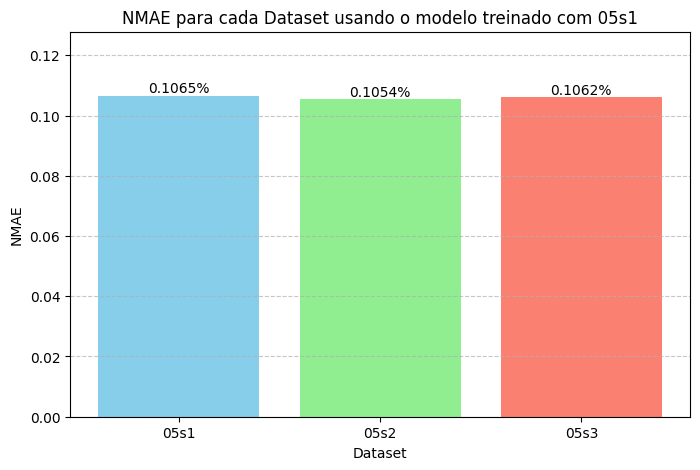

3
3


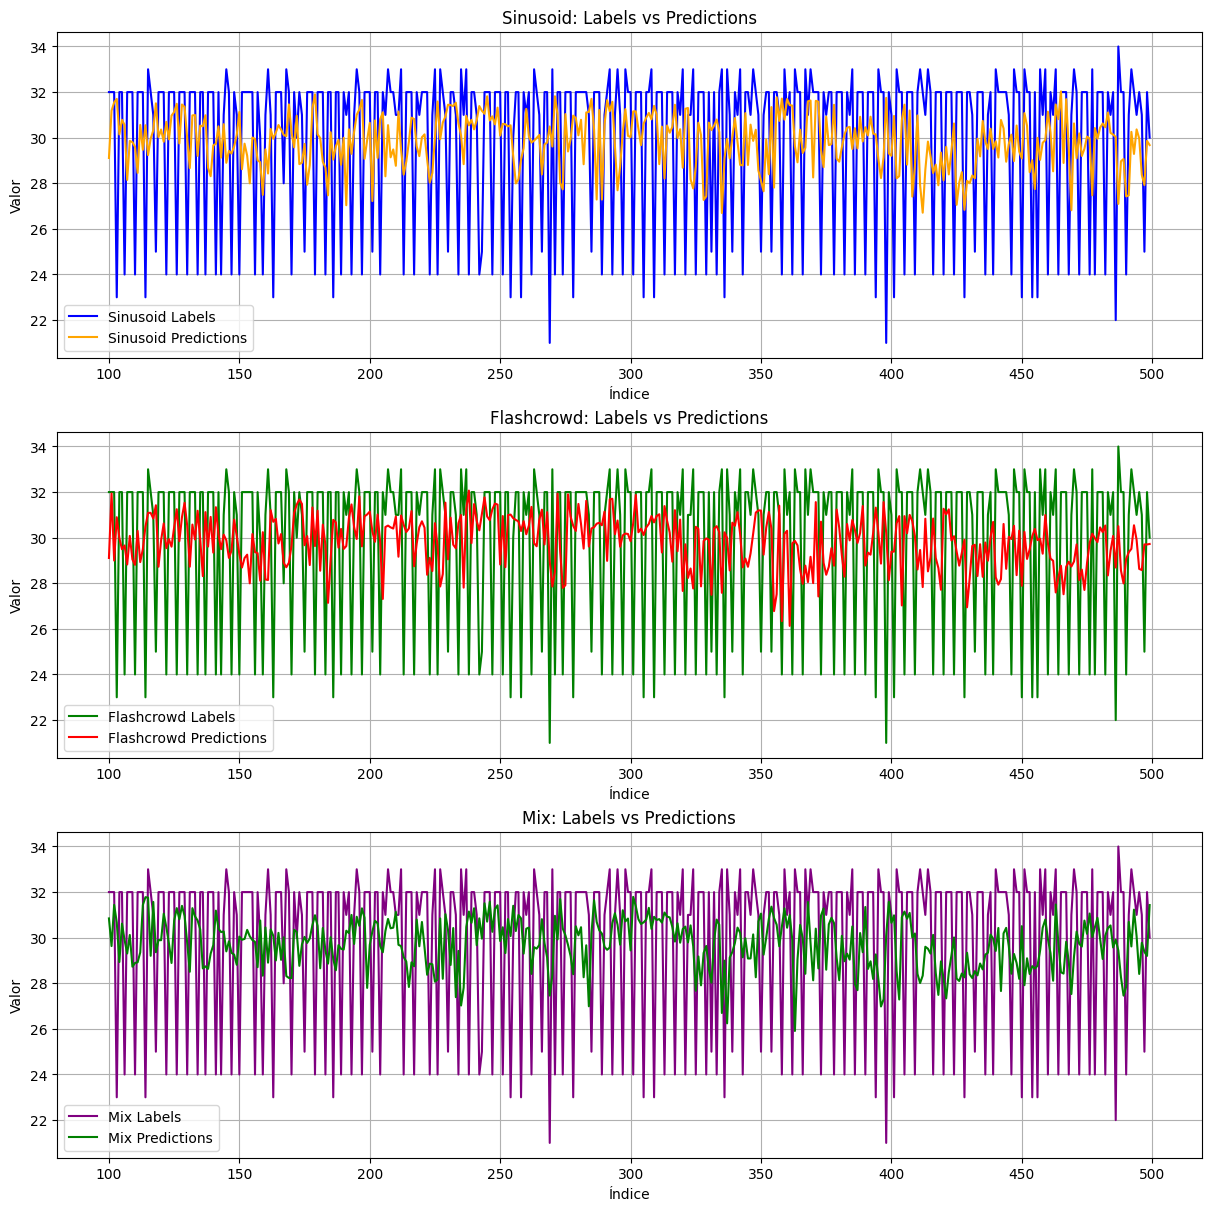

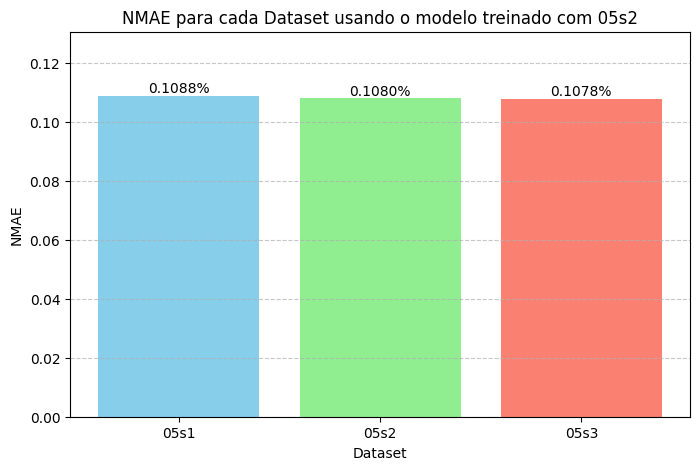

3
3


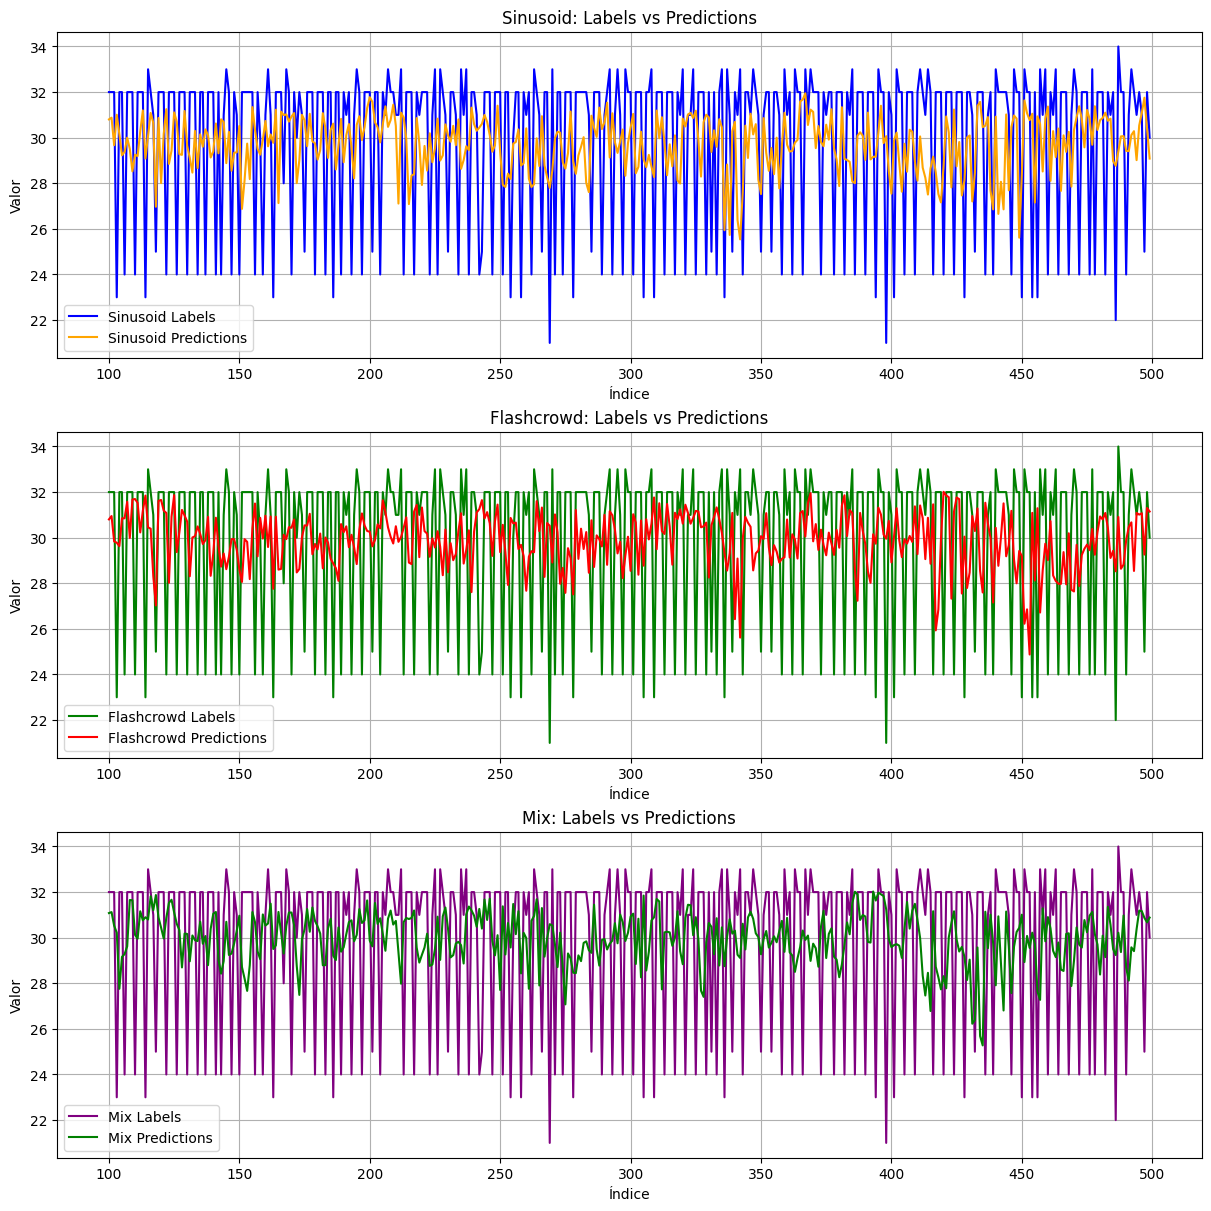

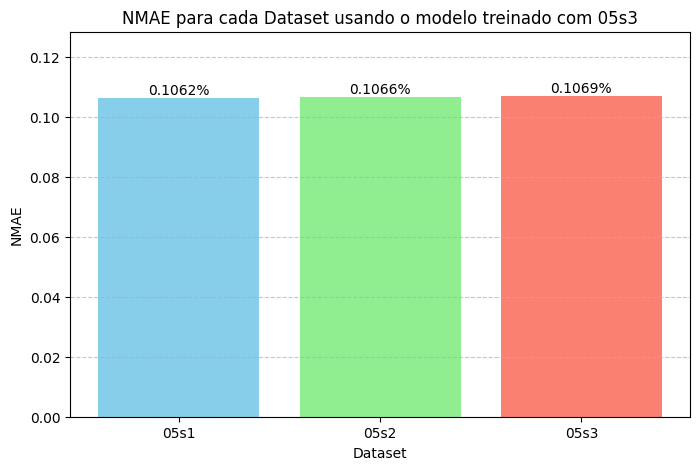

3
3


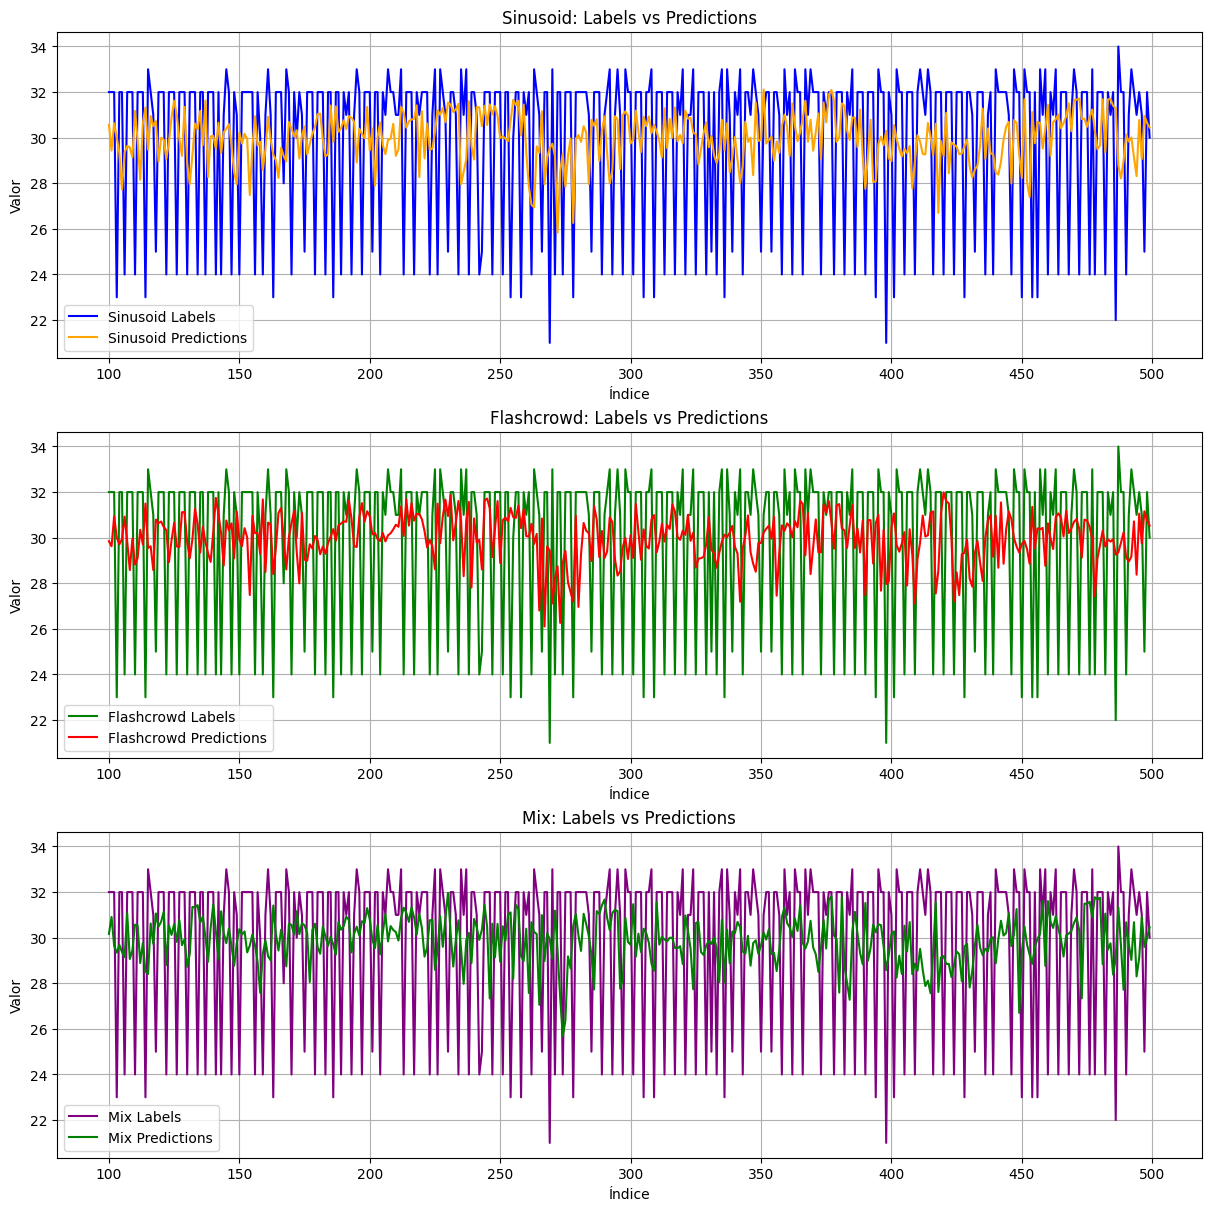

In [47]:
datasets = ['05s1', '05s2', '05s3']
model_names = ['05s1', '05s2', '05s3']
models = [model_05s1, model_05s2, model_05s3]

features_list = [sleep05_switch1, sleep05_switch2, sleep05_switch3]
labels_list = [sleep1_labels, sleep1_labels, sleep1_labels]

for model, model_name in zip(models, model_names):
    predictions = [model.predict(features) for features in features_list]
    nmae_values = [nmae(labels, pred) for labels, pred in zip(labels_list, predictions)]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(datasets, nmae_values, color=['skyblue', 'lightgreen', 'salmon', 'yellow'])
    plt.title(f'NMAE para cada Dataset usando o modelo treinado com {model_name}')
    plt.xlabel('Dataset')
    plt.ylabel('NMAE')
    plt.ylim(0, max(nmae_values) * 1.2)

    for bar, value in zip(bars, nmae_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(),               
            f'{value:.4f}%',               
            ha='center', va='bottom'            
        )
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    plt.show()  

    plot_predictions_comparison(
        start_graph=100, 
        end_graph=500, 
        labels_list=labels_list,
        predictions_list=predictions,
        model_name=model_name
    )


In [35]:
def plot_predictions_comparison(start_graph, end_graph, labels_list, predictions_list, model_name):
    print(len(labels_list))
    print(len(predictions_list))
    datasets_info = [
        ('Switch1', labels_list[0][start_graph:end_graph], predictions_list[0][start_graph:end_graph]),
        ('SWitch2', labels_list[1][start_graph:end_graph], predictions_list[1][start_graph:end_graph]),
        ('SWitch3', labels_list[2][start_graph:end_graph], predictions_list[2][start_graph:end_graph]),
    ]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
    t = np.arange(start_graph, end_graph)

    ax1.plot(t, datasets_info[0][1], label='Sinusoid Labels', color='blue')
    ax1.plot(t, datasets_info[0][2], label='Sinusoid Predictions', color='orange')
    ax1.set_title('Sinusoid: Labels vs Predictions')
    ax1.set_xlabel('Índice')
    ax1.set_ylabel('Valor')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(t, datasets_info[1][1], label='Flashcrowd Labels', color='green')
    ax2.plot(t, datasets_info[1][2], label='Flashcrowd Predictions', color='red')
    ax2.set_title('Flashcrowd: Labels vs Predictions')
    ax2.set_xlabel('Índice')
    ax2.set_ylabel('Valor')
    ax2.grid(True)
    ax2.legend()


    ax3.plot(t, datasets_info[2][1], label='Mix Labels', color='purple')
    ax3.plot(t, datasets_info[2][2], label='Mix Predictions', color='green')
    ax3.set_title('Mix: Labels vs Predictions')
    ax3.set_xlabel('Índice')
    ax3.set_ylabel('Valor')
    ax3.grid(True)
    ax3.legend()

    plt.show()